# Description of notebook

This notebook aims to find descriptions that people are talking about different aspects. In this case, an "aspect" refers to an expression of food within a customer's review, and a "description" refers to the description of the aspect. 

This process is seperated for different competitors, and reviews are categorized to positive and negative sentiments to better understand what people are saying that is good for the company, and seperately for what is bad for the company.

For example, given a positive review "The mentaiko is delicious", the "aspect" will be "mentaiko" and description of the aspect will be "delicious"

# Important

This notebook runs for Fukudon and its competitors. To prevent duplicate notebooks serving the same function, only this notebook will be used. To get ABSA for any competitors, change the corresponding filepath to read the different datasets, under <b>"Import Data"</b> section

# Import libraries and dependencies

In [1]:
import spacy
import re
import collections
import pandas as pd
import numpy as np
import plotly.express as px 
from collections import Counter

In [2]:
!python -m spacy download en_core_web_sm

# Preprocessing functions

In [3]:
def clean_text(text):
    temp = text.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    return temp

In [4]:
# Function to get unique words for each aspect 
def unique_words(aspect_dict, aspect): 
    unique_words_dict = {}
    unique_word_list = []
    for desc in aspect_dict[aspect]:
        if desc not in unique_word_list:
            unique_word_list.append(desc)
        
    return unique_word_list

#get the count for each unique word for each aspect 
def get_counts_desc_list(aspect_dict, aspect):
    count_desc = {}
    count_list = []

    
    for desc in aspect_dict[aspect]:
        if desc not in count_desc:
            count_desc[desc] = 1
        else:
            count_desc[desc] += 1 
    
    for desc in count_desc:
        count_list.append(count_desc[desc])

                        
    
    return count_list 


def get_proportion_desc_list(aspect_dict,aspect):
    count_desc = {}
    count_list = []
    proportion_list = []
    total= 0 
    
    
    for desc in aspect_dict[aspect]:
        if desc not in count_desc:
            count_desc[desc] = 1
        else:
            count_desc[desc] += 1 
    
    for desc in count_desc:
        total += count_desc[desc]
    for desc in count_desc:
        proportion_list.append(count_desc[desc]/total)

                        
    
    return proportion_list 
        

In [5]:
nlp = spacy.load("en_core_web_sm")

# Import Data

In [2]:
pos_reviews = pd.read_csv("../data/competitors/cleaned_and_splitted/stickNbowls_cleaned_pos_reviews.csv", names=['Reviews'], encoding="unicode-escape")
neg_reviews = pd.read_csv("../data/competitors/cleaned_and_splitted/stickNbowls_cleaned_neg_reviews.csv", names=["Reviews"], encoding="unicode-escape")

In [7]:
pos_reviews.head()

Reviews
0                                         unagi toji
1  tasty loklok sticks deep fried version crispy ...
2                                definitely purchase
3  wanting try finally sons loved salmon much gar...
4  amazing find coffee shop serve different type ...

In [8]:
# Remove duplicates from dataframe
pos_reviews = pos_reviews.drop_duplicates("Reviews", inplace = False)
pos_reviews.reset_index(inplace=True)
neg_reviews = neg_reviews.drop_duplicates("Reviews")
neg_reviews.reset_index(inplace=True)

In [9]:
pos_reviews= pos_reviews.drop(columns="index")
neg_reviews = neg_reviews.drop(columns="index")

# Positive Reviews

In [10]:
pos_reviews_list = pos_reviews["Reviews"].to_list()

In [11]:
pos_aspect_list = []

for sentence in pos_reviews_list:
    s = clean_text(sentence)
    doc = nlp(s)
    descriptive_term = ''
    aspects = []
    for token in doc:
        if token.pos_ == 'ADJ' :
            descriptive_term = token
        if token.pos_ == "NOUN" or token.pos_ == "PROPN":
            aspects.append(str(token))
    pos_aspect_list += aspects

In [12]:
# COUNTING ITEMS 
pos_freq = collections.Counter(pos_aspect_list)
top_10_pos= dict(collections.Counter(pos_freq))

In [13]:
top_pos_aspects = []
top_10_pos =dict(top_10_pos)
for key in top_10_pos:
    if top_10_pos[key] >= (len(pos_reviews)*0.1):
        print(key)
        top_pos_aspects.append(key)

unagi
loklok
salmon
portion
mentaiko
time
pork
belly
bowl
rice
price
owner
sauce
garlic
food


In [14]:
print(top_pos_aspects)

['unagi', 'loklok', 'salmon', 'portion', 'mentaiko', 'time', 'pork', 'belly', 'bowl', 'rice', 'price', 'owner', 'sauce', 'garlic', 'food']


## Create dataframe that maps sentence to aspect

In [15]:
# creating a sentence-aspect dictionary 
pos_sent_aspect_dict = {}
for sentence in pos_reviews_list:
    s = clean_text(sentence)
    doc = nlp(s)
    descriptive_term = ''
    aspects = []
    for token in doc:
        if token.pos_ == 'ADJ' :
            descriptive_term = token
        if token.pos_ == "NOUN" or token.pos_ == "PROPN":
            aspects.append(str(token)) #for each sentence, store all the aspects in a list 
            if str(token) in top_pos_aspects:
                pos_sent_aspect_dict[s] = str(token)    

In [16]:
pos_df = pd.DataFrame.from_dict(pos_sent_aspect_dict, orient='index', columns=['Aspect'])
pos_df.head()

Aspect
unagi toji                                           unagi
tasty loklok sticks deep fried version crispy e...    time
wanting try finally sons loved salmon much garl...   belly
amazing find coffee shop serve different type b...  loklok
ordered garlic pork belly rice bowl chose spicy...  loklok

## Create dataframe that maps aspect to description

In [17]:
# Aim to create a asepct-descriptive term df 

temp_pos_asp_descrp_dict = {}
asp = ''
# code 
for sentence in pos_reviews_list:
    s = clean_text(sentence)
    doc = nlp(s)
    descriptive_term = ''

    for token in doc:
        if token.pos_ == 'ADJ' :
            descriptive_term = str(token)
        if token.pos_ == "NOUN" or token.pos_ == "PROPN":
            asp = str(token)
        
        if asp in top_pos_aspects:
            if descriptive_term != '':
                if asp not in temp_pos_asp_descrp_dict:
                    temp_pos_asp_descrp_dict[asp] = descriptive_term
                else:
                    temp_pos_asp_descrp_dict[asp] += ", " + descriptive_term


In [18]:
pos_aspect_descrp_df = pd.DataFrame.from_dict(temp_pos_asp_descrp_dict, orient='index')

In [19]:
pos_aspect_descrp_df.head()

0
loklok    tasty, standard, standard, standard, garlic, y...
salmon    deep, much, garlic, generous, generous, genero...
unagi                                           deep, sweet
portion   deep, good, spicy, generous, overall, generous...
mentaiko  good, generous, reasonable, reasonable, nice, ...

## Visualization
For each aspect, get unique description words (x-axis) and the count(y-axis).

In [20]:
# Put description as a list for each aspect in top_5_neg_aspects:
pos_asp_dict = {}
for asp in temp_pos_asp_descrp_dict:
    content = temp_pos_asp_descrp_dict[asp]
    to_list = content.split(',')
    pos_asp_dict[asp] = to_list

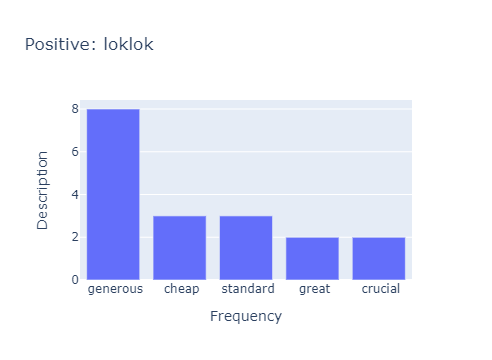

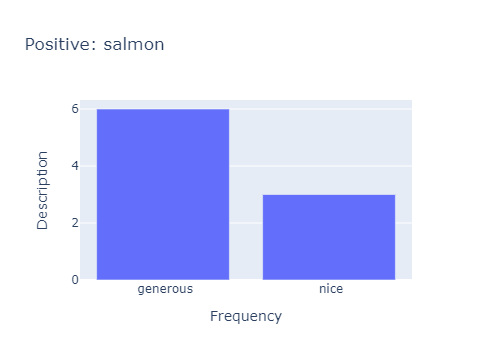

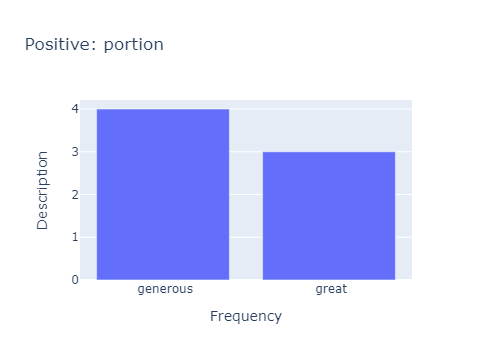

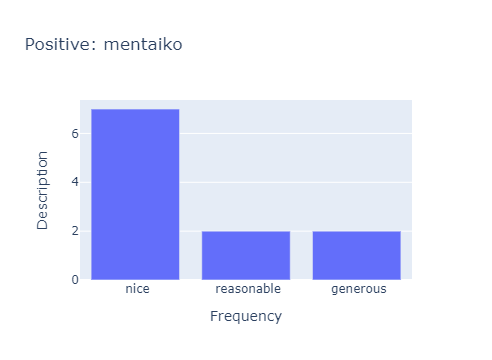

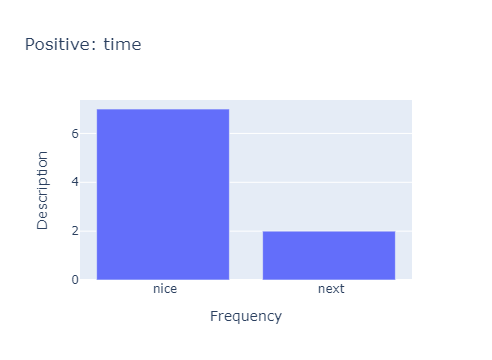

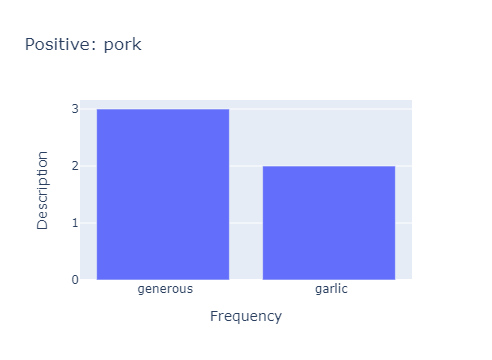

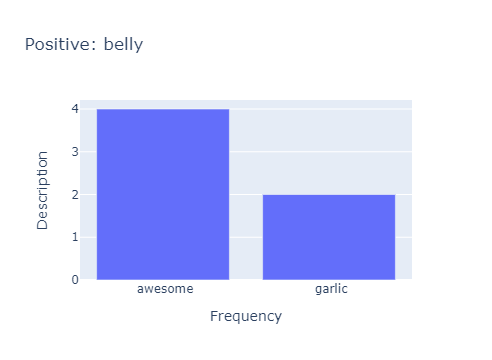

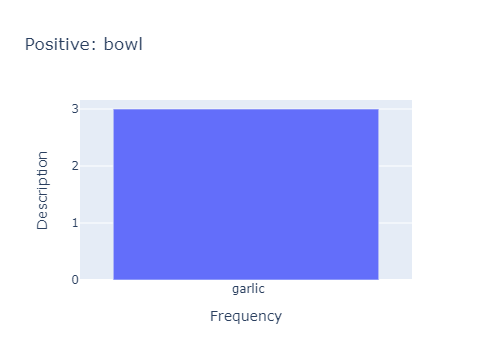

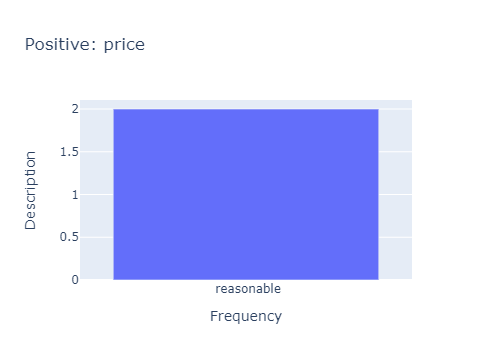

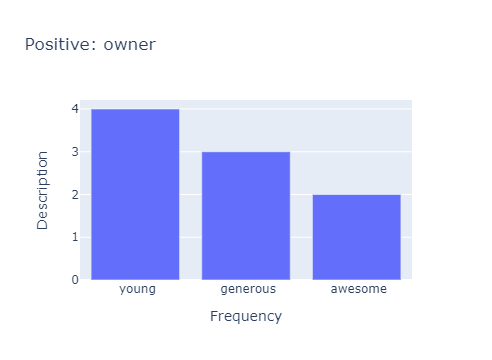

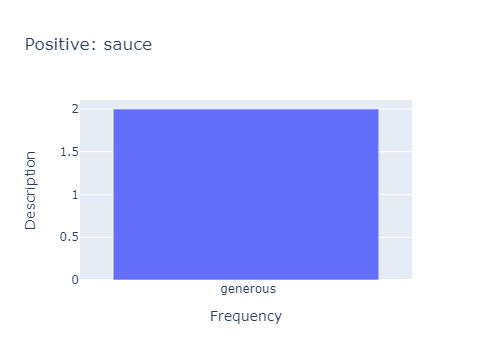

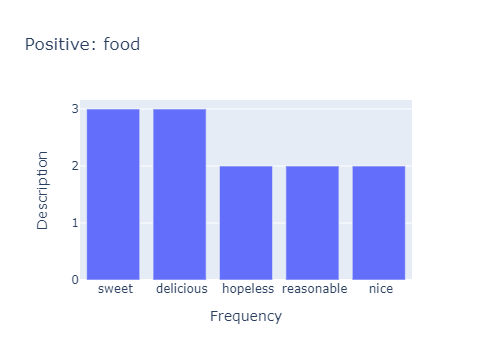

In [21]:
for asp in pos_asp_dict:
    x_list = []
    y_list = []
    for x,y in zip(unique_words(pos_asp_dict,asp),get_counts_desc_list(pos_asp_dict, asp)):
        if y>1:
            x_list.append(x)
            y_list.append(y)
    if len(x_list)!=0:
        fig = px.bar(x= x_list, y= y_list, title="Positive: " + asp, labels=dict(x ="Frequency",y= "Description"))
        fig.update_layout(xaxis={'categoryorder':'total descending'})
        fig.show()

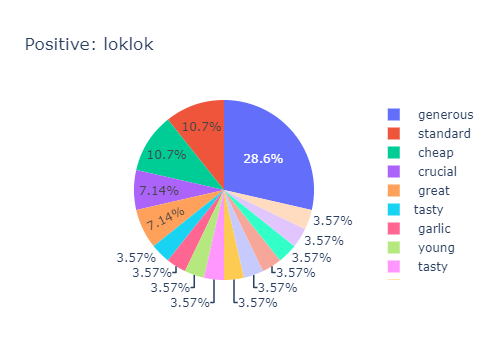

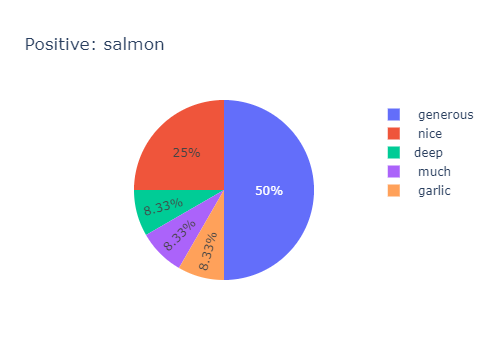

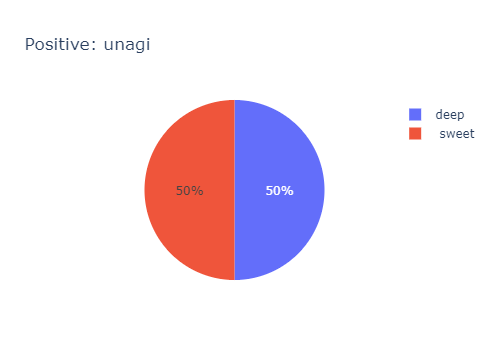

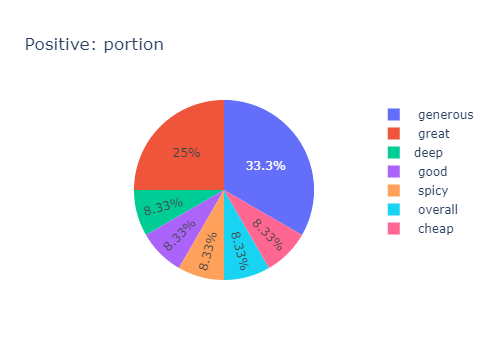

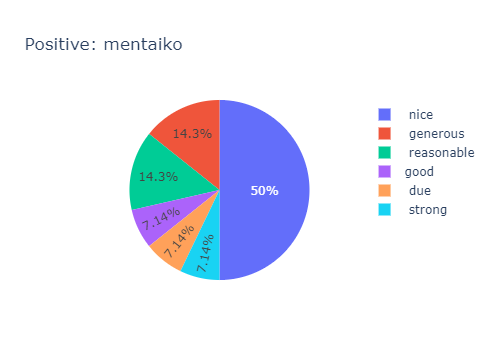

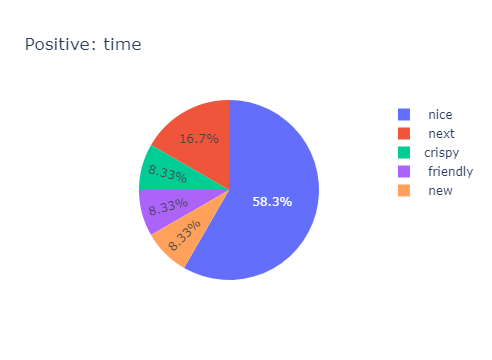

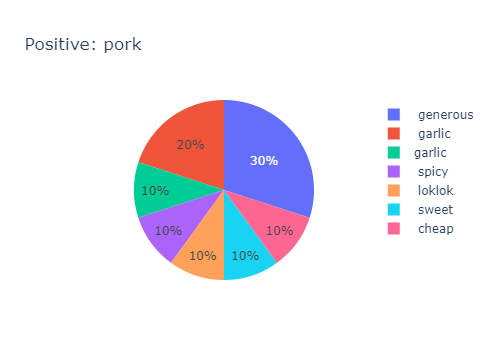

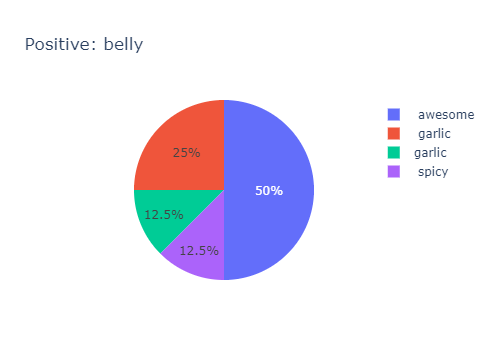

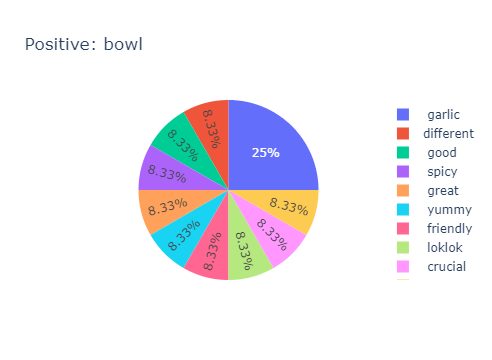

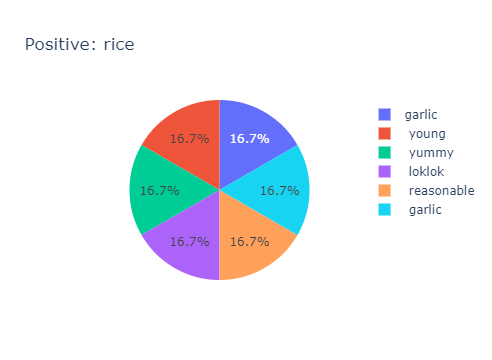

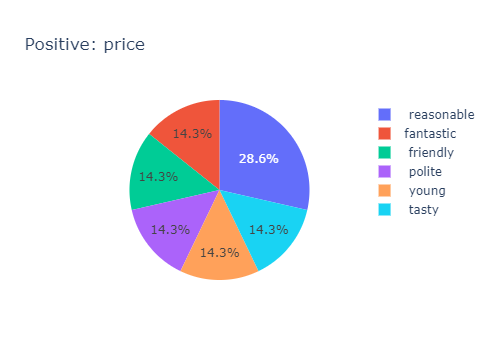

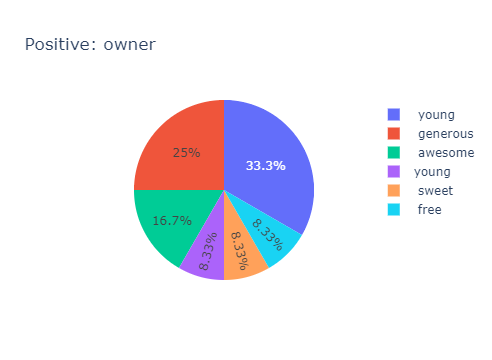

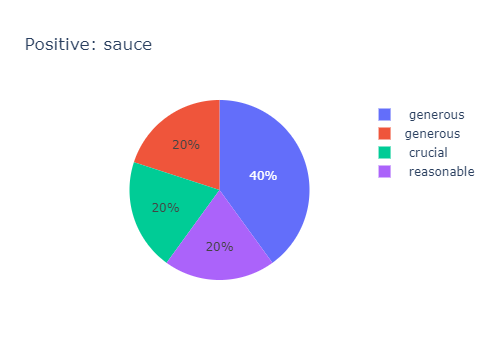

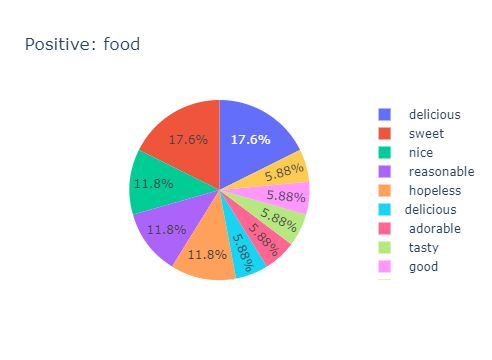

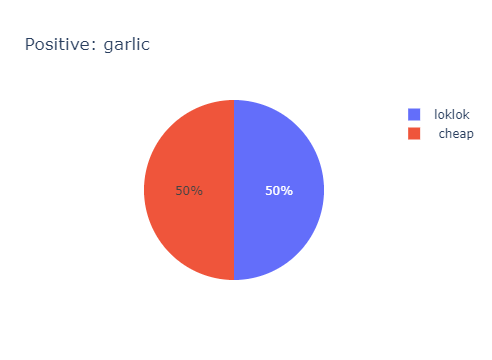

In [22]:
for asp in pos_asp_dict:
    df = pd.DataFrame(unique_words(pos_asp_dict,asp), columns=['Description'])
    df['counts'] = get_counts_desc_list(pos_asp_dict, asp)
    fig = px.pie(df, values= 'counts', names='Description', title='Positive: '+ asp)
    fig.show()

# Negative Reviews

In [23]:
neg_reviews_list = neg_reviews["Reviews"].to_list()  #convert to list 

In [24]:
neg_aspect_list = []
neg_appended = []

for sentence in neg_reviews_list:
    s = clean_text(sentence)
    doc = nlp(s)
    descriptive_term = ''
    aspects = []
    for token in doc:
        if token.pos_ == 'ADJ' :
            descriptive_term = token
        if token.pos_ == "NOUN" or token.pos_ == "PROPN":
            aspects.append(str(token))
    neg_appended.append(aspects)        

    neg_aspect_list += aspects

##### FOR COUNTING OF ITEMS:
    
Please check and see if there are common words that mean the same thing in the top 5. If yes, then change int in most_common to 6 and combine the contents later below.

Else, use <br>
<b>most_common(5)</b>


In [25]:
neg_freq = collections.Counter(neg_aspect_list)

In [26]:
top_neg_aspects = []
top_neg_dict =dict(neg_freq)
for key in top_neg_dict:
    if top_neg_dict[key] >= (len(neg_reviews)*0.1):
        print(key)
        top_neg_aspects.append(key)

mentaiko
loklok
pork
bowl
egg
rice
items
broccoli
sauce
price
toji
belly
owner
end
food
sticks
bag
business
beef
unagi
tender
orders
chicken
return
store
way
portion


## Create dataframe that maps sentence to aspect

In [27]:
neg_sent_aspect_dict = {}
for sentence in neg_reviews_list:
    s = clean_text(sentence)
    doc = nlp(s)
    descriptive_term = ''
    aspects = []
    for token in doc:
        if token.pos_ == 'ADJ' :
            descriptive_term = token
        if token.pos_ == "NOUN" or token.pos_ == "PROPN":
            aspects.append(str(token)) #for each sentence, store all the aspects in a list 
            if str(token) in top_neg_aspects:
                neg_sent_aspect_dict[s] = str(token)

In [28]:
neg_df = pd.DataFrame.from_dict(neg_sent_aspect_dict, orient='index', columns=['Aspect'])

In [29]:
neg_df.head()

Aspect
mentaiko fries loklok                               loklok
looking forward try got super shocked outrageou...     egg
ordered loklok requested go rice technically lo...  loklok
value money first look bowls look small it   s ...     end
food ok im totally disappointed takeaway nonsen...     bag

## Create dataframe that maps aspect to description

In [30]:
# Aim to create a asepct-descriptive term df 

# initialisation
temp_neg_asp_descrp_dict = {}

# code 
for sentence in neg_reviews_list:
    s = clean_text(sentence)
    doc = nlp(s)
    descriptive_term = ''
    aspects = []
    
    for token in doc:
        if token.pos_ == 'ADJ' :
            descriptive_term = str(token)
        if token.pos_ == "NOUN" or token.pos_ == "PROPN":
            asp = str(token)
            aspects.append(str(token)) #for each sentence, store all the aspects in a list 
            
        if asp in top_neg_aspects:
            
            if descriptive_term != '':
                
                if asp not in temp_neg_asp_descrp_dict:
                    temp_neg_asp_descrp_dict[asp] = descriptive_term
                    
                else:
                    temp_neg_asp_descrp_dict[asp] += ',' + descriptive_term


In [31]:
neg_asp_descrp_df = pd.DataFrame.from_dict(temp_neg_asp_descrp_dict, orient='index',columns=['Description'])
neg_asp_descrp_df

Description
loklok    shocked,outrageous,outrageous,outrageous,radis...
pork      outrageous,unagi,garlic,cheap,generous,generou...
bowl      outrageous,outrageous,loklok,loklok,unagi,apol...
egg        outrageous,outrageous,free,free,free,free,garlic
rice      loklok,loklok,loklok,loklok,loklok,loklok,lokl...
items     loklok,loklok,loklok,loklok,loklok,loklok,sour...
broccoli                  loklok,loklok,loklok,loklok,cheap
sauce     sourish,sourish,radish,unagi,generous,salty,ta...
price                       more,reasonable,shameful,decent
toji                                                  unagi
belly                                          unagi,garlic
owner     unagi,unagi,unagi,unagi,generous,generous,gene...
end                                        salty,apologetic
sticks                                   additional,regular
bag       additional,regular,doggy,doggy,doggy,doggy,dog...
food                        regular,regular,regular,regular
business              shameful,shameful,decent,decent,doggy
unagi                                                 tough
tender    tough,tough,tough,worth,worth,worth,worth,wort...
orders                              tough,tough,tough,tough
chicken                    uncook,uncook,uncook,salty,worth
return                                        uncook,uncook
store     uncook,uncook,uncook,long,long,long,long,long,...
beef                                             apologetic
way                            worth,generous,edible,better
portion                             generous,generous,cheap
mentaiko                                           generous

## Visualization

For each aspect, get unique description words (x-axis) and the count(y-axis).

In [32]:
# Put description as a list for each aspect in top_5_neg_aspects:
neg_asp_dict = {}
for asp in temp_neg_asp_descrp_dict:
    content = temp_neg_asp_descrp_dict[asp]
    to_list = content.split(',')
    neg_asp_dict[asp] = to_list

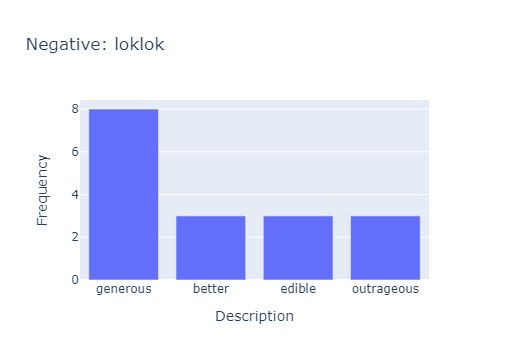

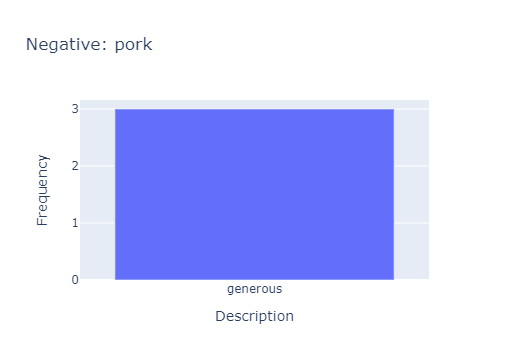

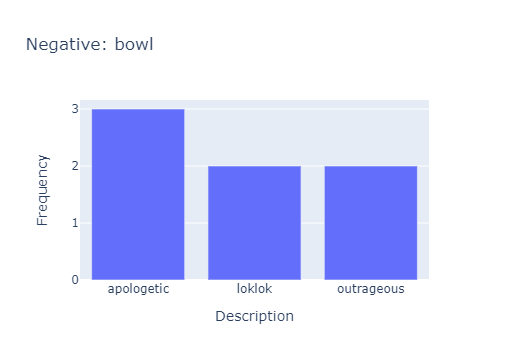

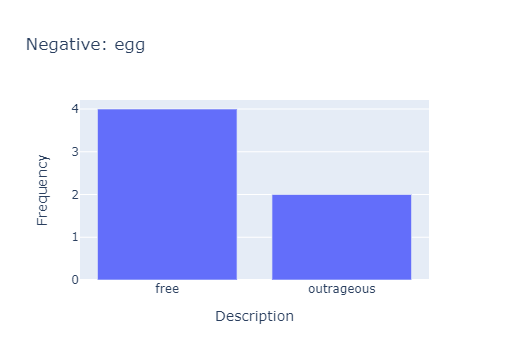

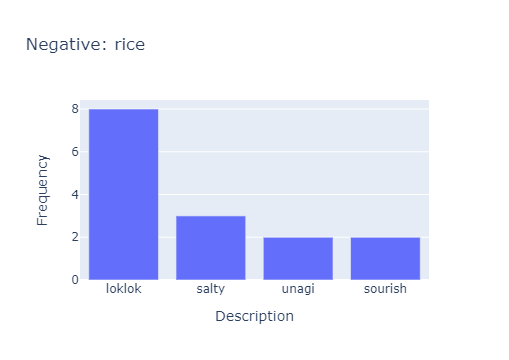

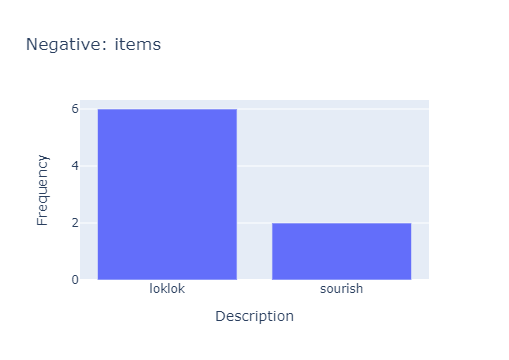

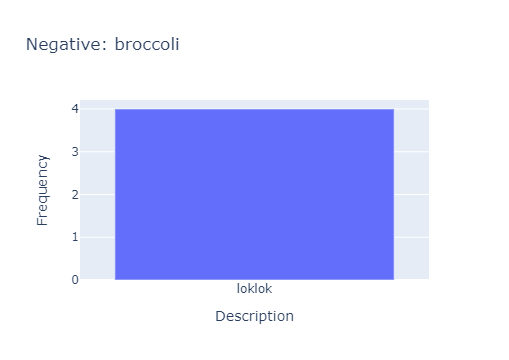

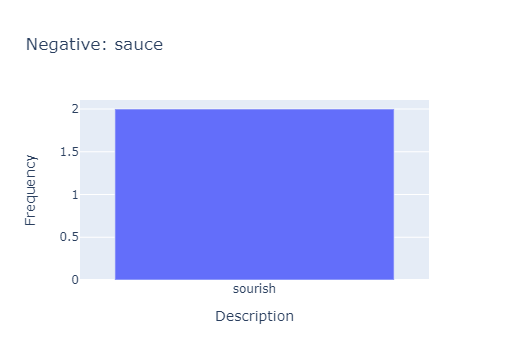

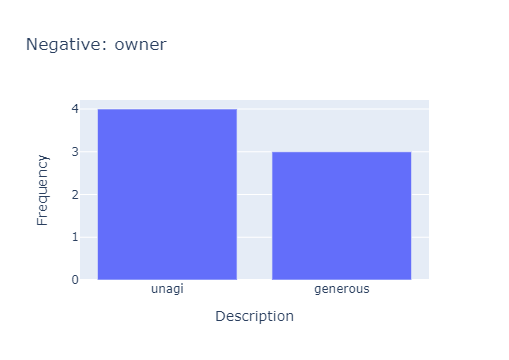

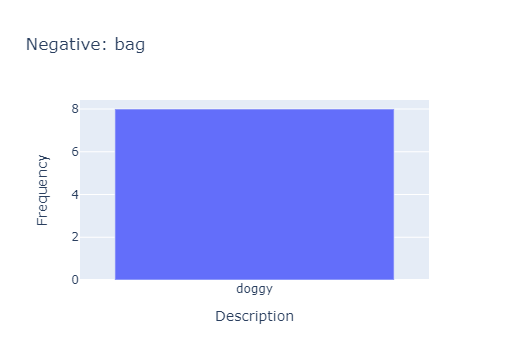

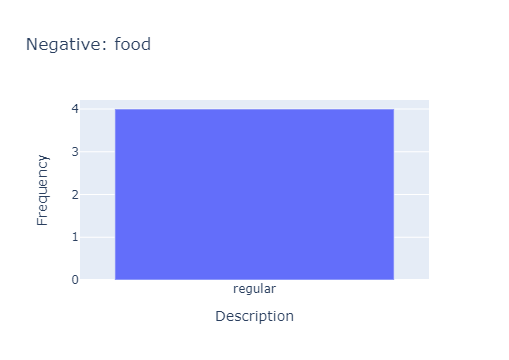

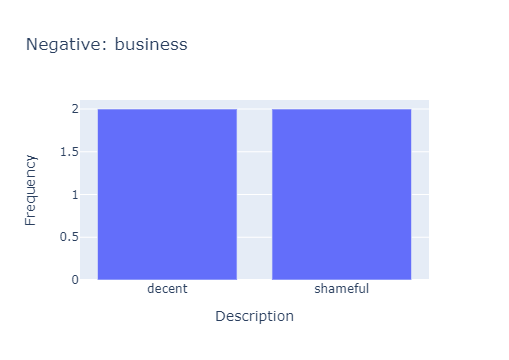

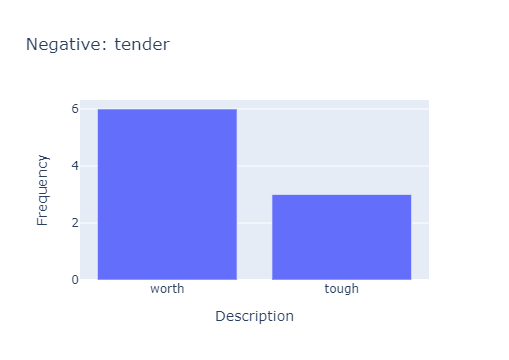

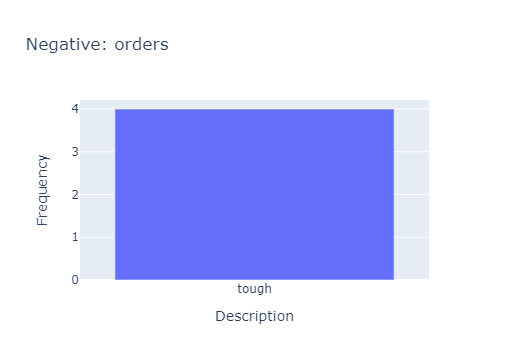

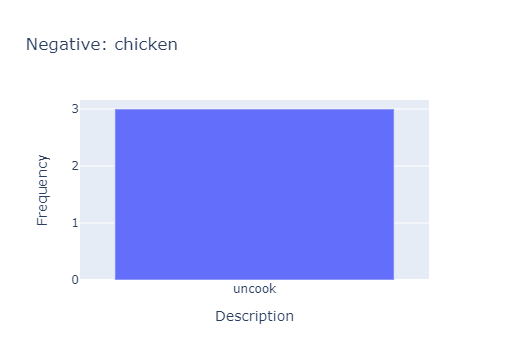

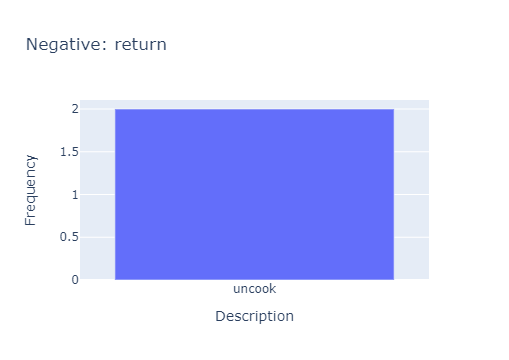

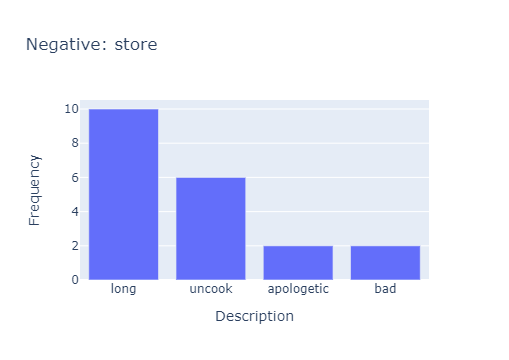

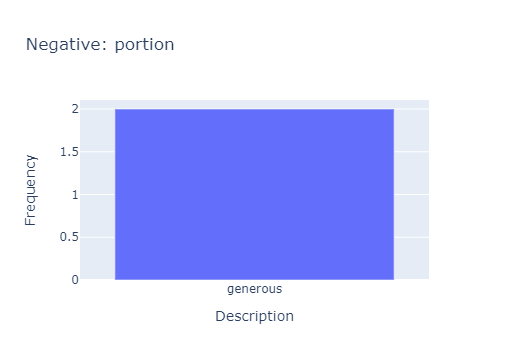

In [33]:
for asp in neg_asp_dict:
    x_list = []
    y_list = []
    for x,y in zip(unique_words(neg_asp_dict,asp),get_counts_desc_list(neg_asp_dict, asp)):
        if y>1:
            x_list.append(x)
            y_list.append(y)
    if len(x_list)!=0:
        fig = px.bar(x= x_list, y= y_list, title="Negative: " + asp, labels=dict(x ="Description",y= "Frequency"))
        fig.update_layout(xaxis={'categoryorder':'total descending'})
        fig.show()

## Proportion Visualisation

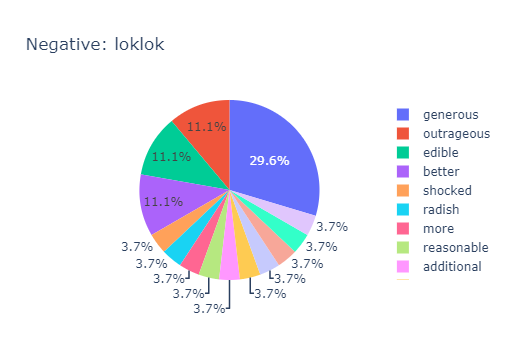

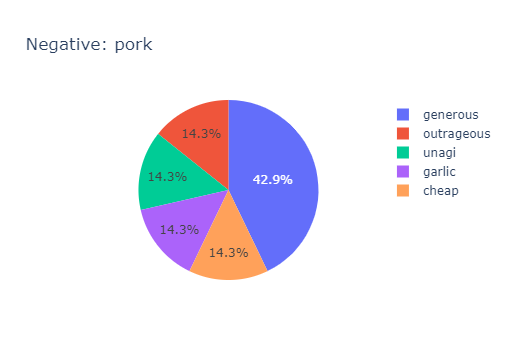

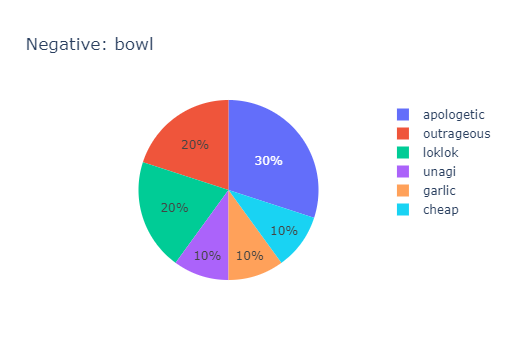

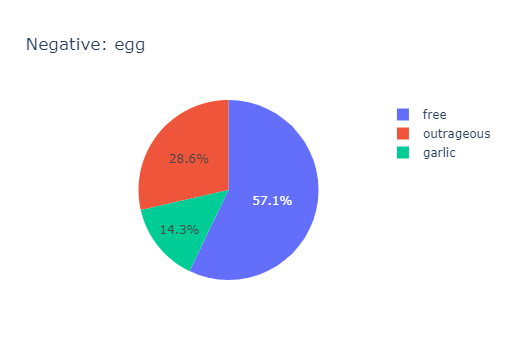

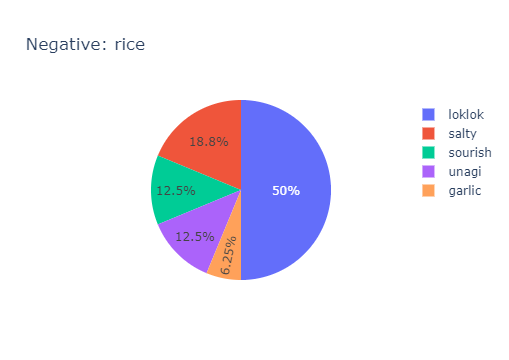

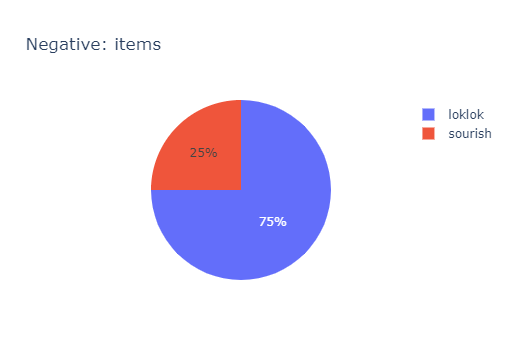

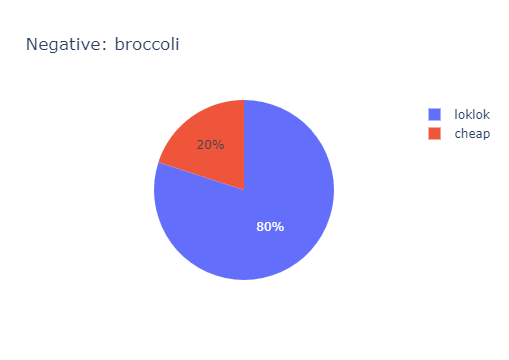

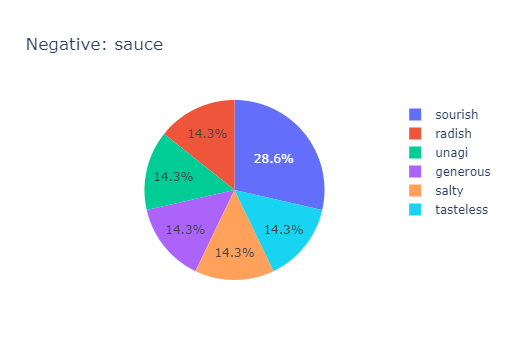

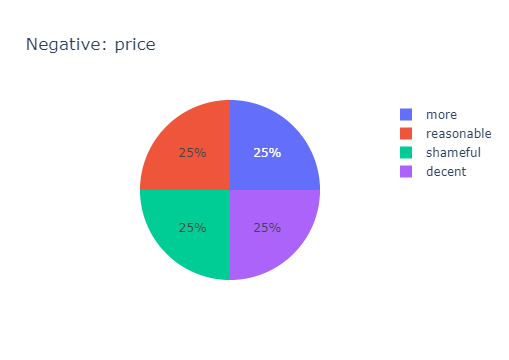

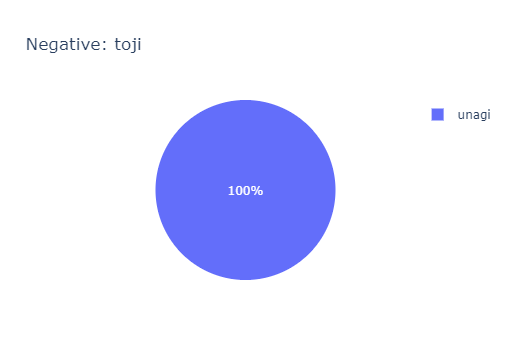

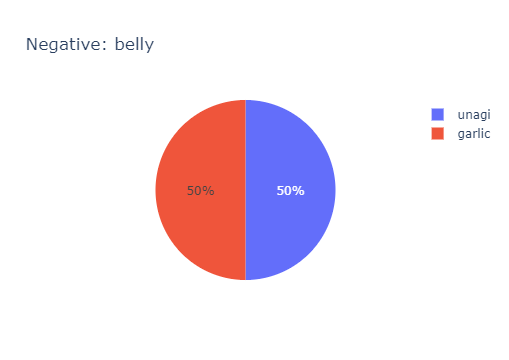

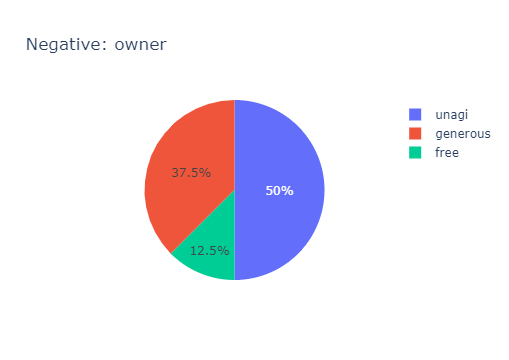

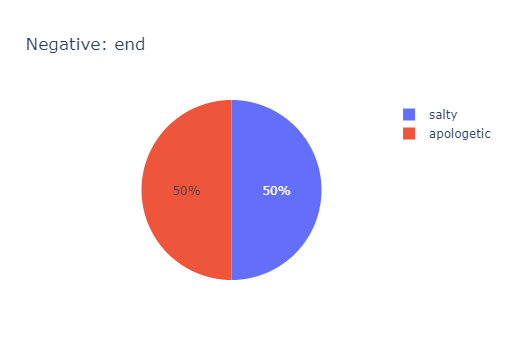

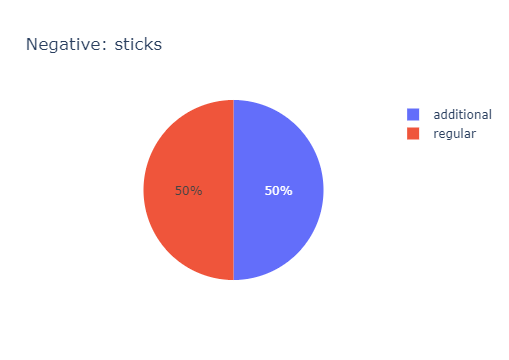

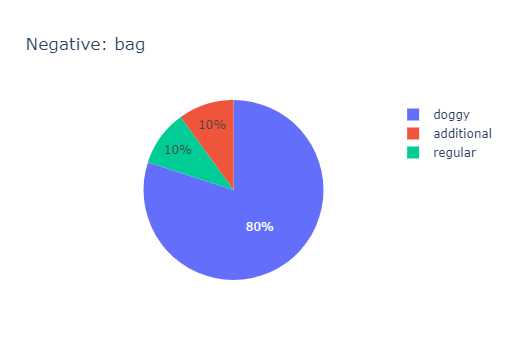

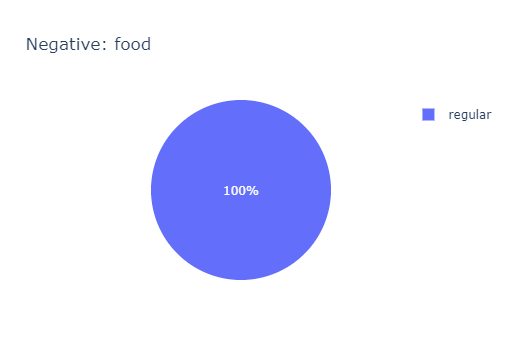

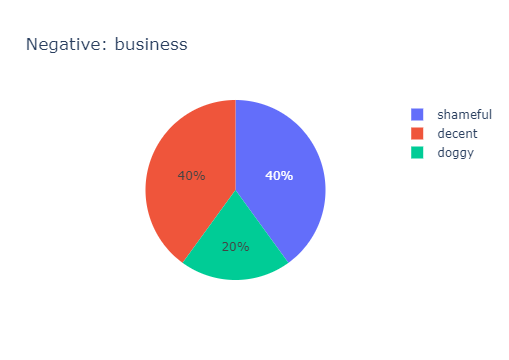

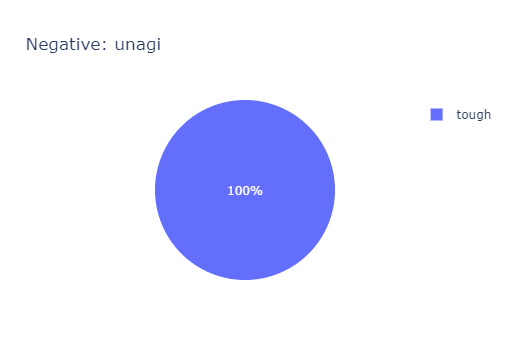

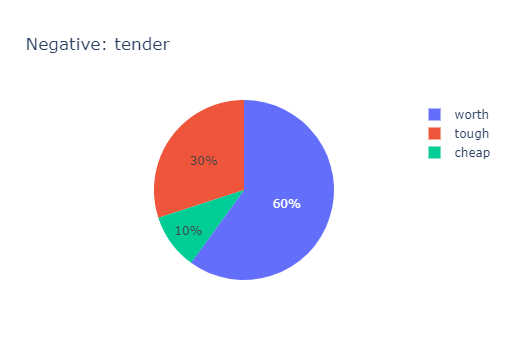

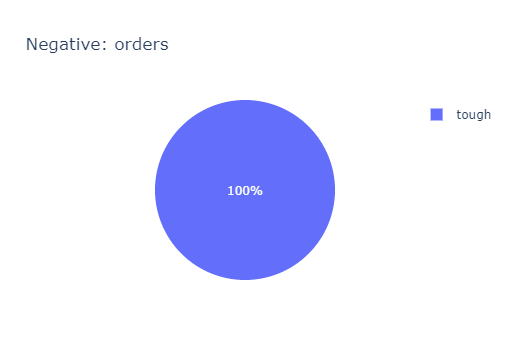

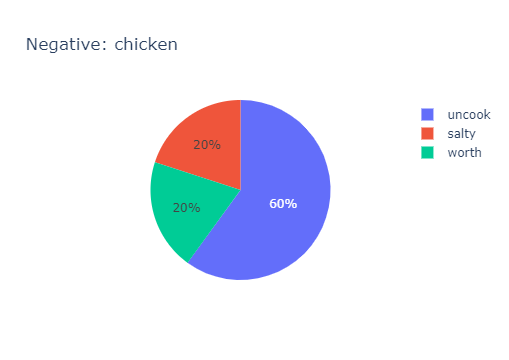

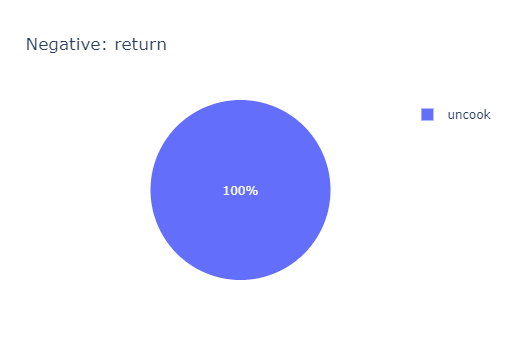

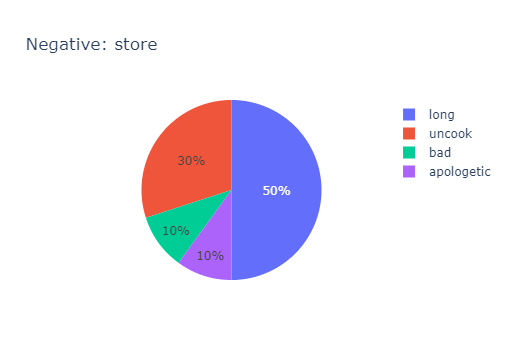

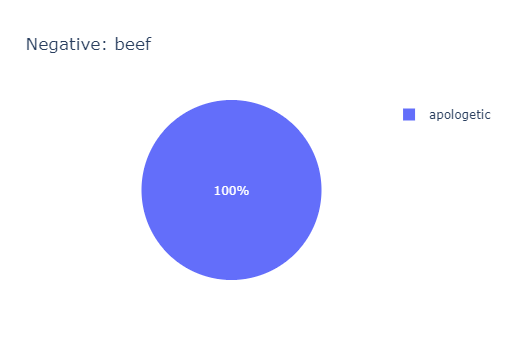

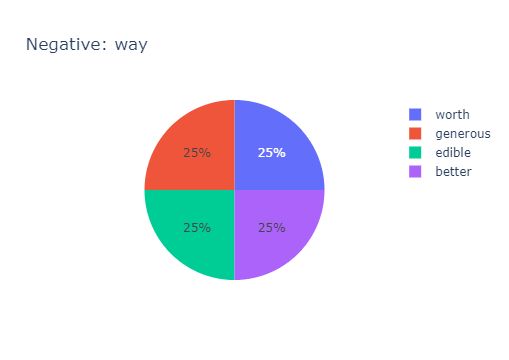

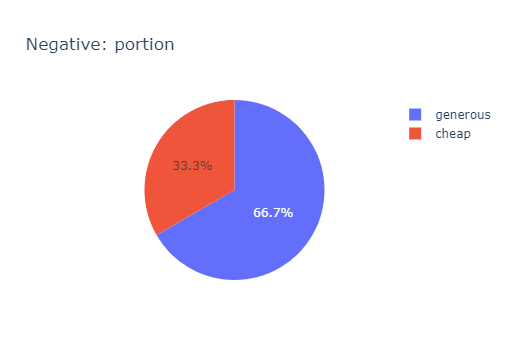

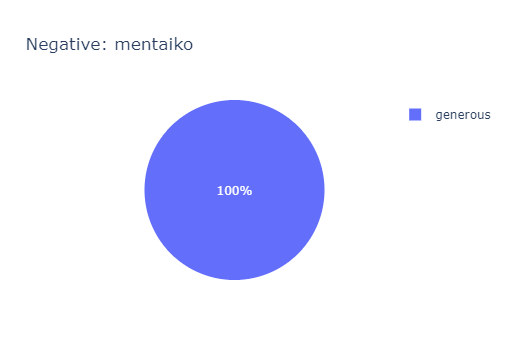

In [34]:
for asp in neg_asp_dict:
    df = pd.DataFrame(unique_words(neg_asp_dict,asp), columns=['Description'])
    df['counts'] = get_counts_desc_list(neg_asp_dict, asp)
    fig = px.pie(df, values= 'counts', names='Description', title='Negative: '+ asp)
    fig.show()